#### Выбор метрик

Для принятия решения нужно учесть несколько метрик. По моему мнению, для бизнеса в данной ситуации основной метрикой является средяя выручка.

**Целевая метрика:**  
* средняя выручка  

**Прокси метрики:**  
* средний чек заказа;  
* среднее количество заказов;  
* среднее количество отмененных заказов; 
* среднее количество уникальных товаров в заказе.  

**Группа 0 (контрольная группа)** — пользователи со старой версией приложения, где нет рекомендации товаров.  
**Группа 1 (экспериментальная группа)** —  пользователи с новой системой рекомендаций.

### Проведу EDA

Импортирую необходимые для работы библиотеки, считываю данные, формирую датафреймы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import pingouin as pg
from matplotlib import pyplot as plt
# Отключаю предупреждения
import warnings
warnings.filterwarnings("ignore")

#### users_data_df — хранит историю заказов пользователей  
- **user_id**	— уникальный id пользователя;  
- **order_id** — уникальный id заказа;  
- **action** — действие c заказом (create_order, cancel_order);  
- **time** — дата и время действия;  
- **date** — только дата действия;  
- **group** — номер группы к которой относится пользователь.

In [2]:
users_data_df = pd.read_csv("./data/ab_users_data.csv")

In [3]:
# Посмотрю на первые 5 строк DF
users_data_df.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
print(f'\033[1m users_data_df состоит из {users_data_df.shape[1]} колонок и {users_data_df.shape[0]} строк \033[0m')

 users_data_df состоит из 6 колонок и 4337 строк 


In [5]:
# Посмотрю на тип данных
users_data_df.info()
print()
print('\033[1mКолонки time и date имеют тип данных object. Желательно перевести их в формат datetime. \033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB

Колонки time и date имеют тип данных object. Желательно перевести их в формат datetime. 


In [6]:
# В колонке time оставляю только время, так как дата дублируется в колонке date. Колонку date перевожу в формат datetime
users_data_df['time'] = pd.to_datetime(users_data_df['time']).dt.time
users_data_df['date'] = pd.to_datetime(users_data_df['date'], format='%Y-%m-%d')

In [7]:
# Посмотрю есть ли пропущенные значения
number_of_passes = users_data_df.isnull().sum().sum()

if number_of_passes == 0:
    print('\033[1m Пропущенные значения отсутствуют. \033[0m')
else:
    print('\033[1m Присутствуют пропущенные значения! \033[0m')
    print(users_data_df.isnull().sum())

 Пропущенные значения отсутствуют. 


In [8]:
# Проверю строки датафрейма на дубли
num_duplicates = users_data_df.duplicated().sum()
print(f"\033[1m Количество дублирующихся строк: {num_duplicates} \033[0m")

 Количество дублирующихся строк: 0 


In [9]:
# Проверю что бы каждый user_id был только в одной группе

# Создам множества с user_id каждой группы
user_id_group0 = set(users_data_df[users_data_df.group == 0].user_id)
user_id_group1 = set(users_data_df[users_data_df.group == 1].user_id)

# Проверю есть ли пересечения. Если есть, то выведу user_id, которые пересекаются
if user_id_group0.isdisjoint(user_id_group1):
    print("\033[1m Пересечения user_id не найдены \033[0m")
else:
    print(f"\033[1m Имеются пересечения следующих user_id: {user_id_group0.intersection(user_id_group1)}\033[0m")

 Пересечения user_id не найдены 


In [10]:
# Проверю что бы каждый order_id был только в одной группе

# Создам множества с user_id каждой группы
order_id_group0 = set(users_data_df[users_data_df.group == 0].order_id)
order_id_group1 = set(users_data_df[users_data_df.group == 1].order_id)

# Проверю есть ли пересечения. Если есть, то выведу order_id, которые пересекаются
if order_id_group0.isdisjoint(order_id_group1):
    print("\033[1m Пересечения order_id не найдены \033[0m")
else:
    print(f"\033[1m Имеются пересечения следующих order_id: {order_id_group0.intersection(order_id_group1)}\033[0m")

 Пересечения order_id не найдены 


#### orders_df — информация о составе заказа  
* **order_id** — уникальный id заказа;  
* **creation_time** — дата и время создания заказа;  
* **product_ids** — список id продуктов в заказе (строковые представления).

In [11]:
orders_df = pd.read_csv("./data/ab_orders.csv")

In [12]:
# Посмотрю на первые 5 строк DF
orders_df.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [13]:
print(f'\033[1m orders_df состоит из {orders_df.shape[1]} колонок и {orders_df.shape[0]} строк\033[0m')

 orders_df состоит из 3 колонок и 4123 строк


In [14]:
# Посмотрю на тип данных
orders_df.info()
print()
print('\033[1mКолонка creation_time имеет тип данных object, переведу в datetime. \033[0m')
print('\033[1mКолонка product_ids имеет тип данных object, переведу в int64. \033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB

Колонка creation_time имеет тип данных object, переведу в datetime. 
Колонка product_ids имеет тип данных object, переведу в int64. 


In [15]:
# Переведу колонку creation_time в формат datetime
orders_df['creation_time'] = pd.to_datetime(orders_df['creation_time'], format="%Y-%m-%d %H:%M:%S.%f")

In [16]:
# В product_ids через лямбда функцию убираю {} и разбиваю строку по ', '. Для каждой строки получаю список с id продуктов.
orders_df['product_ids'] = orders_df['product_ids'].map(lambda x: x.replace('{', '').replace('}', '').split(', '))

# При помощи метода explode разбиваю список с id продуктов на отдельные записи, теперь в одной строке будет только один id продукта. Переименовываю product_ids в product_id
orders_df = orders_df.explode('product_ids').rename(columns=({'product_ids': 'product_id'}))

# Меняю тип данных для колонки product_id с object на int64 для последующего джойна с ab_products.csv
orders_df['product_id'] = orders_df['product_id'].astype('int64')

In [17]:
# Посмотрю, что получилось
orders_df.head(3)

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53


In [18]:
# Посмотрю есть ли пропущенные значения
number_of_passes = orders_df.isnull().sum().sum()

if number_of_passes == 0:
    print('\033[1m Пропущенные значения отсутствуют \033[0m')
else:
    print('\033[1m Присутствуют пропущенные значения! \033[0m')
    print(orders_df.isnull().sum())

 Пропущенные значения отсутствуют 


In [19]:
# Проверю строки датафрейма на дубли
num_duplicates = orders_df.duplicated().sum()
print(f"\033[1m Количество дублирующихся строк: {num_duplicates} \033[0m")

 Количество дублирующихся строк: 276 


In [20]:
# Имеются дубли, посмотрю подробнее
orders_df[orders_df.duplicated(keep=False)].head()

,order_id,creation_time,product_id
13,1269,2022-08-26 00:12:58,67
13,1269,2022-08-26 00:12:58,67
32,1293,2022-08-26 00:37:46,17
32,1293,2022-08-26 00:37:46,17
34,1295,2022-08-26 00:38:23,34


Вижу, что дубли связаны с тем, что в одном заказе (order_id) может быть несколько одинаковых товаров. Поэтому их можно игнорировать.  
Для примера возьму order_id 1269, 1293 и посмотрю в исходный датафрейм, что бы в этом убедиться.  

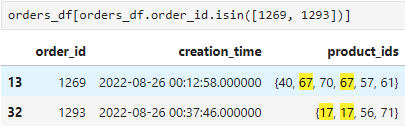

#### products_df — данные о продуктах
* **product_id** — уникальный id продукта;<br>
* **name** — наименование продукта;<br>
* **price** — стоимость продукта.

In [21]:
products_df = pd.read_csv("./data/ab_products.csv")

In [22]:
# Посмотрю на первые 5 строк DF
products_df.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [23]:
print(f'\033[1m products_df состоит из {products_df.shape[1]} колонок и {products_df.shape[0]} строк\033[0m')

 products_df состоит из 3 колонок и 87 строк


In [24]:
# Посмотрю на тип данных
products_df.info()
print()
print('\033[1m Все колонки имеют корректный тип данных \033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB

 Все колонки имеют корректный тип данных 


In [25]:
# Посмотрю есть ли пропущенные значения
number_of_passes = products_df.isnull().sum().sum()

if number_of_passes == 0:
    print('\033[1m Пропущенные значения отсутствуют \033[0m')
else:
    print('\033[1m Присутствуют пропущенные значения! \033[0m')
    print(orders_df.isnull().sum())

 Пропущенные значения отсутствуют 


In [26]:
# Проверю строки датафрейма на дубли
num_duplicates = products_df.duplicated().sum()
print(f"\033[1m Количество дублирующихся строк: {num_duplicates} \033[0m")

 Количество дублирующихся строк: 0 


### Сформирую DF с которыми буду работать
* **data_and_orders_df** — промежуточный DF состоящий из <i>users_data_df</i> и <i>orders_df</i>
* **cancel_orders_id** — список с order_id отмененных заказов
* **not_cancel_ordrs_df** — DF с заказами, которые не были отменены
* **all_df** — объедененный DF состоящий из <i>users_data_df</i>, <i>orders_df</i> и <i>products_df</i>

In [27]:
# Сджойню users_data_df и orders_df
data_and_orders_df = users_data_df.merge(orders_df, on='order_id')

In [28]:
# Сджойню data_and_orders_df и products_df
all_df = data_and_orders_df.merge(products_df, on='product_id')

In [29]:
# Сформирую список с order_id отмененных заказов
cancel_orders_id = all_df.query("action == 'cancel_order'")['order_id'].unique()

In [30]:
# DF с заказами, которые не были отменены
not_cancel_ordrs_df = all_df.query("order_id not in @cancel_orders_id")

In [31]:
# Функция для проверки тяжести хвоста. В дальнейшем пригодится в тестах
def check_tail_heaviness(data, alpha=0.05):
    ks_stat, ks_p = st.kstest(data, 'norm')
    if ks_p < alpha:
        print(f'\033[1m Данные имеют тяжелый хвост (p-value: {ks_p}) \033[0m')
    else:
        print(f'\033[1m Данные имеют легкий хвост (p-value: {ks_p}) \033[0m')

# Прокси метрики

## Test #1 (средний чек заказа)
**Посмотрю на средний чек заказа в обеих группах (не учитывая отмененные order_id)**  

In [32]:
aov = not_cancel_ordrs_df.groupby(['group', 'order_id'], as_index=False) \
                         .agg({'price': 'sum'}) \
                         .groupby(['group']) \
                         .agg({'price': 'mean'}) \
                         .round(2) \
                         .rename(columns=({'price': 'aov'}))
delta_percent = (aov['aov'].max() / aov['aov'].min()) * 100 - 100
print(aov)
print()
print(f"\033[1mЕсть различия, у контрольной группы средний чек заказа больще на {delta_percent:.1f} %. При помощи статистического теста определю статистически значимы эти различия или нет. \033[0m")

          aov
group        
0      382.09
1      368.86

Есть различия, у контрольной группы средний чек заказа больще на 3.6 %. При помощи статистического теста определю статистически значимы эти различия или нет. 


In [33]:
# Подготовлю датафрейм для проведения теста
test_1 = not_cancel_ordrs_df.groupby(['group', 'order_id'], as_index=False) \
                            .agg({'price': 'sum'}) \
                            .rename(columns=({'price': 'total'}))
print("\033[1m total — сумма заказа \033[1m")
test_1.head(3)

 total — сумма заказа 


,group,order_id,total
0,0,1255,408.7
1,0,1257,310.2
2,0,1261,430.7


### Визуальная проверка

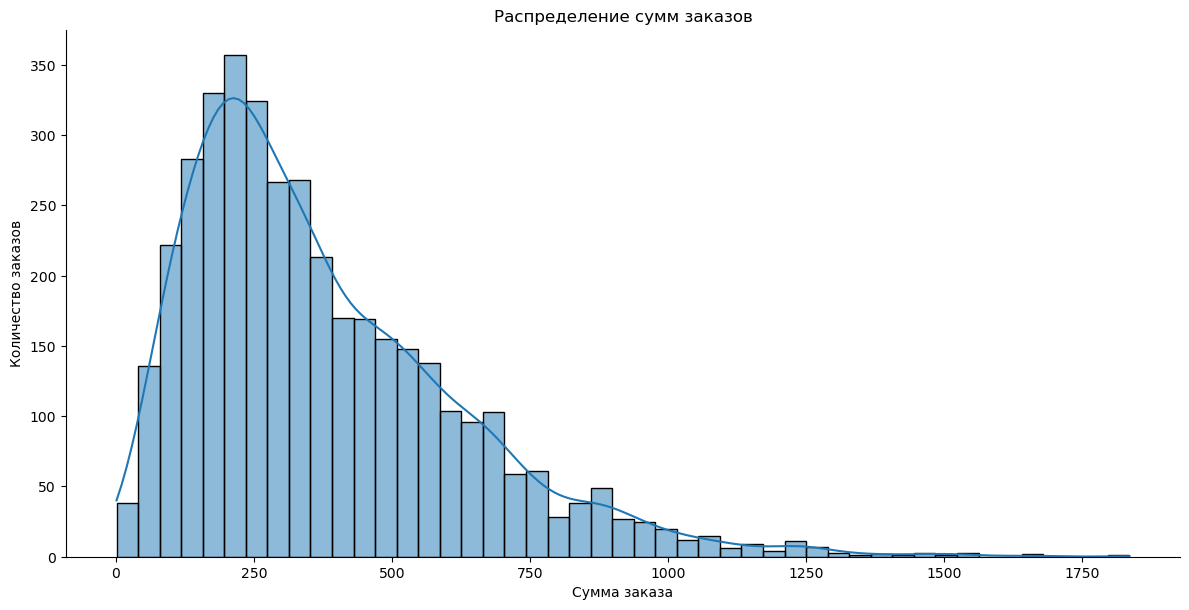

 Значения распределены относительно симметрично, но с большим хвостом справа 


In [34]:
# Посмотрю как распределены значения из колонки total
sns.displot(data=test_1, x="total", kde=True, height= 6, aspect= 2)
# Добавлю название гистограмме и ее осям
plt.title('Распределение сумм заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество заказов')
plt.show()

print("\033[1m Значения распределены относительно симметрично, но с большим хвостом справа \033[0m")

In [35]:
# Добавлю колонку с прологарифмированными значениями, что бы сделать распределения более симметричными
test_1['total_log'] = np.log(test_1.total)

print("\033[1m total_log — прологарифмированная сумма заказа \033[1m")
test_1.head(3)

 total_log — прологарифмированная сумма заказа 


,group,order_id,total,total_log
0,0,1255,408.7,6.012981
1,0,1257,310.2,5.737217
2,0,1261,430.7,6.065412


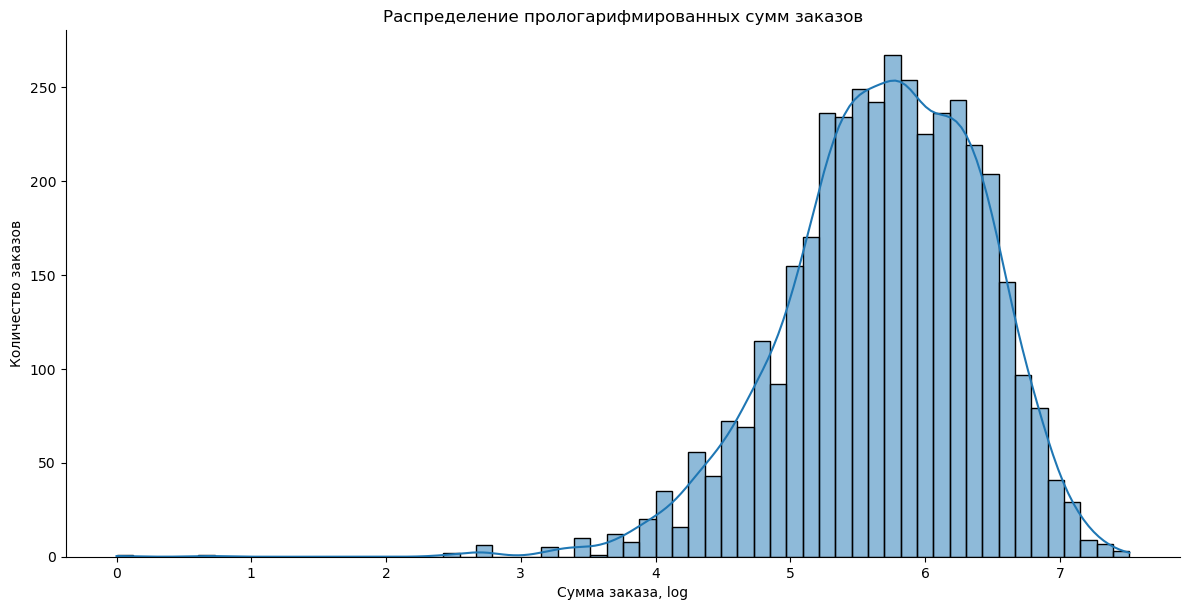

Распределение имеет более симметричный вид, в отличие от непрологарифмированных значений. Имеется ощутимый хвост слева. Дальше в тесте буду работать со значениями из total_log.  


In [36]:
# Посмотрю на прологарифмированные значения из колонки total_log
sns.displot(data=test_1, x="total_log", kde=True, height= 6, aspect= 2)

# Добавлю название гистограмме и ее осям
plt.title('Распределение прологарифмированных сумм заказов')
plt.xlabel('Сумма заказа, log')
plt.ylabel('Количество заказов')
plt.show()

print("\033[1mРаспределение имеет более симметричный вид, в отличие от непрологарифмированных значений. Имеется ощутимый хвост слева. Дальше в тесте буду работать со значениями из total_log.  \033[0m")

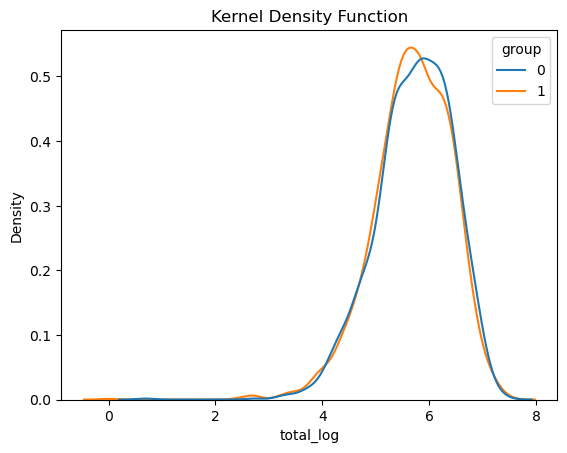

In [37]:
# При помощи kdeplot посмотрю на плотность распределения значений для каждой группы
sns.kdeplot(x='total_log', data=test_1, hue='group', common_norm=False);
plt.title("Kernel Density Function");
plt.show()

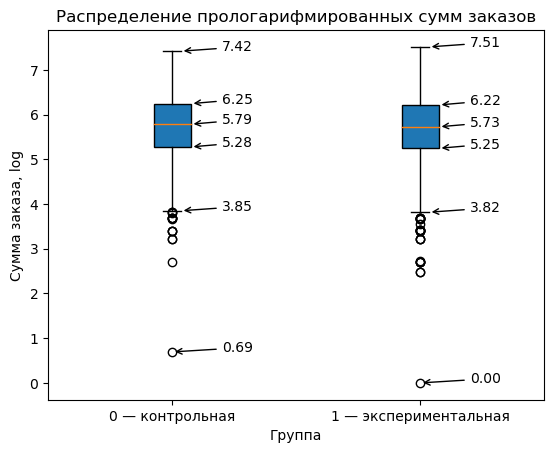

 Значения в группах очень схожи, но в экспериментальной группе больше выбросов и они находятся дальше. 
 В контрольной группе выброс с минимальным значением относится к order_id 27687, в котором два товара 'пакет бумажный'. 
 В экспериментальная группе выброс с минимальным значением относится к order_id 55000, в котором один товар 'пакет бумажный'. 


In [38]:
# Разделю на отдельные группы
data0 = test_1[test_1.group == 0]['total_log'].values  # контрольная группа
data1 = test_1[test_1.group == 1]['total_log'].values  # экспериментальная группа

# Создание боксплота
fig, ax = plt.subplots()
bp = ax.boxplot([data0, data1], patch_artist=True)

# Добавлю название гистограмме и ее осям
plt.title('Распределение прологарифмированных сумм заказов')
plt.xlabel('Группа')
plt.ylabel('Сумма заказа, log')

# Подпись значений квартилей, усов и выбросов для каждой группы
for i, group_data in enumerate([data0, data1], start=0):
    
    quartiles = np.percentile(group_data, [25, 50, 75])
    
    # Подписи квартилей (25, 50, 75)
    for q in quartiles:
        ax.annotate(f'{q:.2f}', xy=(i + 1.075, q), xytext=(i + 1.2, q),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')

    
    # Максимальное и минимальное значение в группе
    max_val = np.max(group_data)
    min_val = np.min(group_data)

    # Значения усов (верхний и нижний)
    lower_whiskers =  bp['whiskers'][2 * i].get_ydata()[1]
    upper_whiskers = bp['whiskers'][2 * i + 1].get_ydata()[1]  
    
    # Подписи выбросов (максимальных и минимальных)
    if max_val != upper_whiskers:
        ax.annotate(f'{max_val:.2f}', xy=(i + 1, max_val), xytext=(i + 1.2, max_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')
    if min_val != lower_whiskers:
        ax.annotate(f'{min_val:.2f}', xy=(i + 1, min_val), xytext=(i + 1.2, min_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')    
   
    # Подписи усов (верхний и нижний)
    ax.annotate(f'{lower_whiskers:.2f}', xy=(i + 1.035, lower_whiskers), xytext=(i + 1.2, lower_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')
    ax.annotate(f'{upper_whiskers:.2f}', xy=(i + 1.035, upper_whiskers), xytext=(i + 1.2, upper_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')

# Настройка меток осей
ax.set_xticklabels(['0 — контрольная', '1 — экспериментальная'])
plt.show()

print("\033[1m Значения в группах очень схожи, но в экспериментальной группе больше выбросов и они находятся дальше. \033[0m")
print("\033[1m В контрольной группе выброс с минимальным значением относится к order_id 27687, в котором два товара 'пакет бумажный'. \033[0m")
print("\033[1m В экспериментальная группе выброс с минимальным значением относится к order_id 55000, в котором один товар 'пакет бумажный'. \033[0m")

In [39]:
# Контрольная группа, заказ с минимальной суммой
all_df[all_df.order_id == 27687]

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
5526,1168,27687,create_order,22:54:44,2022-09-02,0,2022-09-02 22:54:44,54,пакет бумажный,1.0
5527,1168,27687,create_order,22:54:44,2022-09-02,0,2022-09-02 22:54:44,54,пакет бумажный,1.0


In [40]:
# Экспериментальная группа, заказ с минимальной суммой
all_df[all_df.order_id == 55000]

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
5580,1402,55000,create_order,07:01:21,2022-09-08,1,2022-09-08 07:01:21,54,пакет бумажный,1.0


### Статистические тесты

#### Проверка нормальности распределения данных при помощи **pg.normality**  

**<u>Определю гипотезы:</u>**  
* H0: значения из колонки total_log распределены нормально  
* H1: распределение значений из колонки total_log является ненормальным

In [41]:
pg.normality(data=test_1, dv='total_log', group='group', method='normaltest')

,W,pval,normal
group,,,
0,150.781890,1.811877e-33,False
1,294.576398,1.080309e-64,False


**Вывод:**  
Значения p-value в обеих группах меньше альфа-уровня (0.05). Это означает, что у меня нет достаточных оснований, что бы принять H0.<br>
**Принимаю H1**, распределение значений из колонки total_log являются ненормальными.

#### Проверка данных на нормальность и гомогенность (гомоскедастичность) дисперсии  

Для проверки равенства дисперсий в группах воспользуюсь тестом Левина, т.к. его рекомендуется использовать при ненормальном распределении.  

**<u>Определю гипотезы:</u>**  
* H0: дисперсии между группами равны
* H1: дисперсии между группами не равны

In [42]:
# Воспользуюсь функцией check_tail_heaviness для определения типа хвоста (тяжелый/легкий) 
check_tail_heaviness(test_1['total_log'])

 Данные имеют тяжелый хвост (p-value: 0.0) 


In [43]:
# Сравню дисперсии тестом Левина. Параметр center='trimmed' — рекомендуется для распределений с тяжелыми хвостами
test_stat, pvalue = st.levene(test_1[test_1.group == 0].total_log, test_1[test_1.group == 1].total_log, center='trimmed')
if pvalue > 0.05:
    print(f"\033[1mСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня не имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. \033[0m")
else:
    print(f"\033[1mСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.\033[0m")

Статистика = 0.35, p-value = 0.5527709315764066.
Это означает, что у меня не имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. 


### Итог по результатам статистических тестов и визуальной проверки
Исходя из предварительного анализа, результатов теста на нормальность и гомогенность дисперсий, подойдет классический t-test (t-критерий Стьюдента). Данный тест может быть использован для сравнения средних при ненормальном распределении, особенно на больших выборках. Для теста необходимо соблюдение гомогенности дисперсий.

### T-test
<b>Тип данных:</b> количественные, непрерывные.<br>
<b>Целевая метрика:</b> средний чек заказа<br>

**<u>Определю гипотезы:</u>**
* H0 - средний чек заказа между контрольной и экспериментальной группой статистически значимо не различается<br>
* H1 - наблюдаемый эффект это результат внедрения в приложение умной системы рекомендации товаров, разница статистически значима

In [44]:
test_stat, pvalue = st.ttest_ind(test_1[test_1.group == 0].total_log, test_1[test_1.group == 1].total_log)
print(f"\033[1m- статистика теста = {round(test_stat, 2)}\n- p-value = {pvalue}\033[0m")

- статистика теста = 1.75
- p-value = 0.07981582868828002


<b>Вывод:</b><br>
P-value больше альфа-уровня (0.05). Таким образом у меня не имеется достаточных оснований, чтобы сказать, что значения в группах статистически значимо различаются. **Принимаю H0.**<br>
Рекомендация товаров существенно не повлияла на средний чек заказа. Средний чек между экспериментальной и контрольной группой статистически значимо не различается.

## Test #2 (среднее количество уникальных товаров в заказе)
**Посмотрю на среднее количество уникальных товаров в заказе (не учитывая отмененные order_id)**  
Смотрю именно уникальные товары, т.к. считаю, что новая фича с рекомендацией товаров в первую очередь рассчитана не на увеличение общего количества товаров, а направленна на покупку разнообразного товара.

In [45]:
aoq = not_cancel_ordrs_df.groupby(['order_id', 'group'], as_index=False) \
                         .agg({'product_id': 'nunique'}) \
                         .rename(columns=({'product_id': 'amount'})) \
                         .groupby(['group']) \
                         .agg({'amount': 'mean'}) \
                         .rename(columns=({'amount': 'aoq'}))
delta_percent = (aoq['aoq'].max() / aoq['aoq'].min()) * 100 - 100
print(aoq)
print()
print(f"\033[1mЕсть различия, у экспериментальной группы среднее количество уникальных товаров в заказе больще на {delta_percent:.1f} %. При помощи статистического теста определю статистически значимы эти различия или нет. \033[0m")

            aoq
group          
0      3.275049
1      3.283795

Есть различия, у экспериментальной группы среднее количество уникальных товаров в заказе больще на 0.3 %. При помощи статистического теста определю статистически значимы эти различия или нет. 


In [46]:
# Подготовлю датафрейм для проведения теста
test_2 = not_cancel_ordrs_df.groupby(['group', 'order_id'], as_index=False) \
                            .agg({'product_id': 'nunique'}) \
                            .rename(columns=({'product_id': 'total'}))
print("\033[1m total — количество уникальных товаров в заказе \033[1m")
test_2.head(3)

 total — количество уникальных товаров в заказе 


,group,order_id,total
0,0,1255,4
1,0,1257,4
2,0,1261,4


### Визуальная проверка

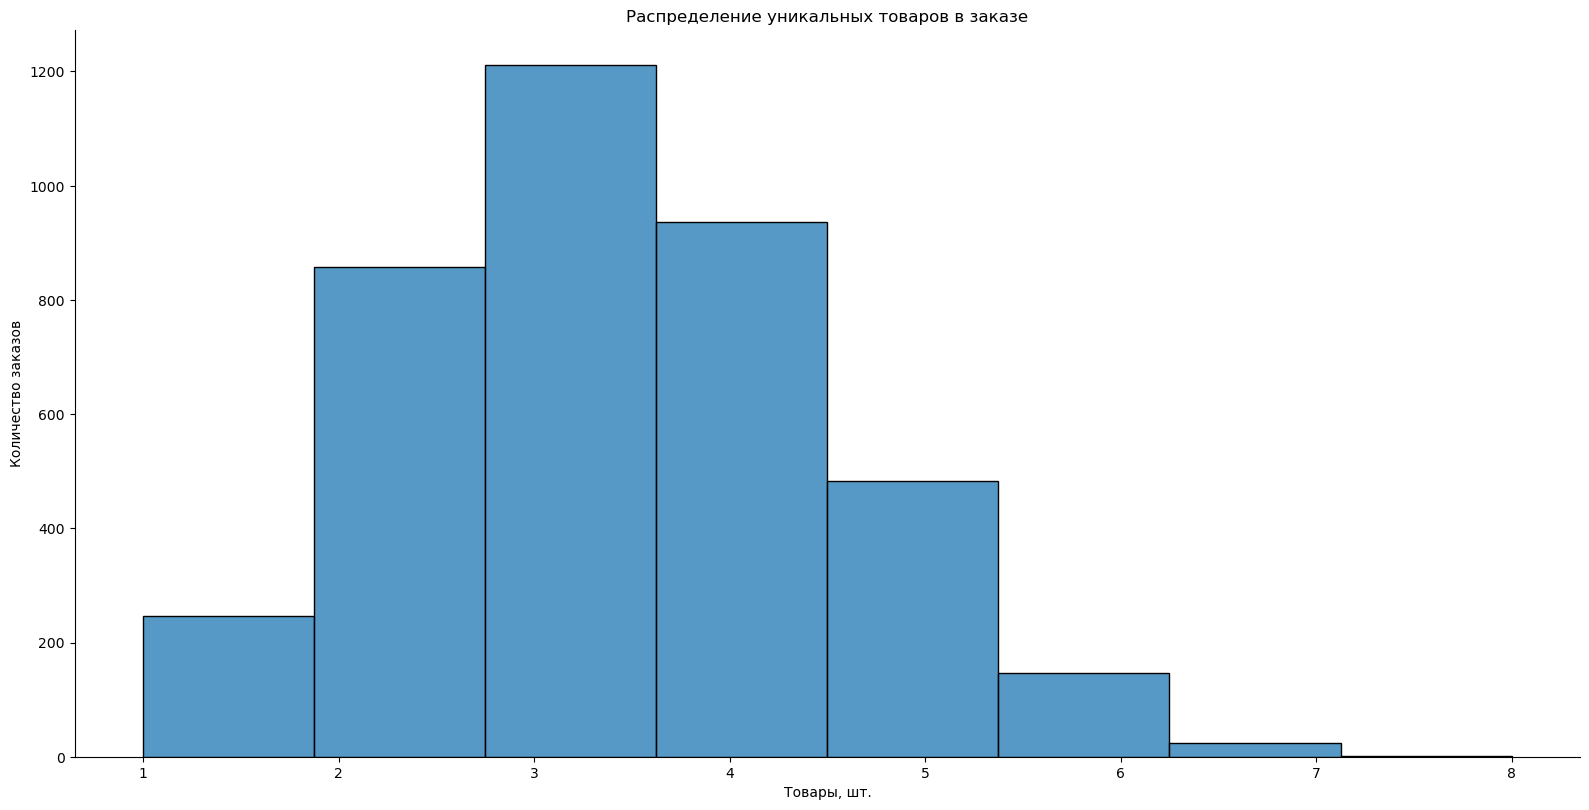

Значения распределены относительно симметрично, но имеется небольшой хвост справа 


In [47]:
# Посмотрю как распределены значения из колонки total
sns.displot(data=test_2, x="total", height= 8, aspect= 2, bins=8)

# Добавлю название гистограмме и ее осям
plt.title('Распределение уникальных товаров в заказе')
plt.xlabel('Товары, шт.')
plt.ylabel('Количество заказов')
plt.show()

print("\033[1mЗначения распределены относительно симметрично, но имеется небольшой хвост справа \033[0m")

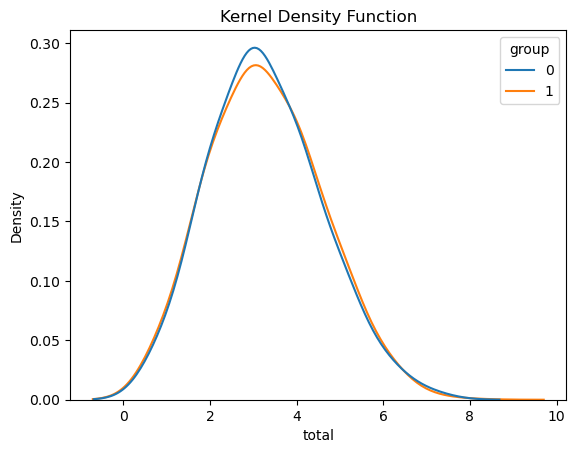

In [48]:
# При помощи kdeplot посмотрю на плотность распределения значений для каждой группы
sns.kdeplot(x='total', data=test_2, hue='group', common_norm=False, bw_method=0.45);
plt.title("Kernel Density Function");
plt.show()

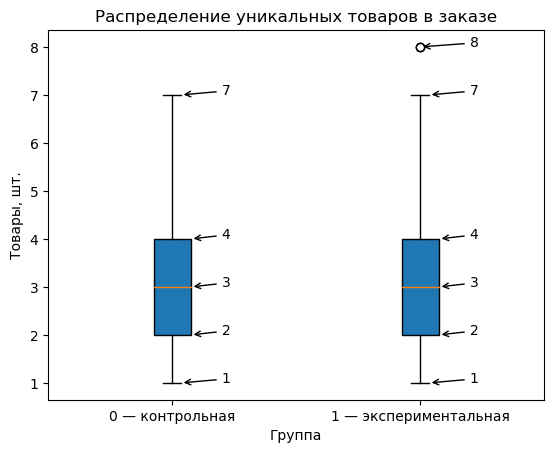

Значения в группах схожи, но в экспериментальной группе имеются выбросы со значением total = 8. 
Данные выбросы относится к order_id 3465 и 6033. 


In [49]:
# Разделю на отдельные группы
data0 = test_2[test_2.group == 0]['total'].values  # контрольная группа
data1 = test_2[test_2.group == 1]['total'].values  # экспериментальная группа

# Создание боксплота
fig, ax = plt.subplots()
bp = ax.boxplot([data0, data1], patch_artist=True)

# Добавлю название гистограмме и ее осям
plt.title('Распределение уникальных товаров в заказе')
plt.xlabel('Группа')
plt.ylabel('Товары, шт.')

# Подпись значений квартилей, усов и выбросов для каждой группы
for i, group_data in enumerate([data0, data1], start=0):
    
    quartiles = np.percentile(group_data, [25, 50, 75])
    
    # Подписи квартилей (25, 50, 75)
    for q in quartiles:
        ax.annotate(f'{q:.0f}', xy=(i + 1.075, q), xytext=(i + 1.2, q),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')

    
    # Максимальное и минимальное значение в группе
    max_val = np.max(group_data)
    min_val = np.min(group_data)

    # Значения усов (верхний и нижний)
    lower_whiskers =  bp['whiskers'][2 * i].get_ydata()[1]
    upper_whiskers = bp['whiskers'][2 * i + 1].get_ydata()[1]  
    
    # Подписи выбросов (максимальных и минимальных)
    if max_val != upper_whiskers:
        ax.annotate(f'{max_val:.0f}', xy=(i + 1, max_val), xytext=(i + 1.2, max_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')
    if min_val != lower_whiskers:
        ax.annotate(f'{min_val:.0f}', xy=(i + 1, min_val), xytext=(i + 1.2, min_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')    
   
    # Подписи усов (верхний и нижний)
    ax.annotate(f'{lower_whiskers:.0f}', xy=(i + 1.035, lower_whiskers), xytext=(i + 1.2, lower_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')
    ax.annotate(f'{upper_whiskers:.0f}', xy=(i + 1.035, upper_whiskers), xytext=(i + 1.2, upper_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')

# Настройка меток осей
ax.set_xticklabels(['0 — контрольная', '1 — экспериментальная'])
plt.show()

print("\033[1mЗначения в группах схожи, но в экспериментальной группе имеются выбросы со значением total = 8. \033[0m")
print("\033[1mДанные выбросы относится к order_id 3465 и 6033. \033[0m")

In [50]:
# Экспериментальная группа, заказы со значением total == 8
test_2.query("group == 1 and total == 8")

,group,order_id,total
2234,1,3465,8
2442,1,6033,8


In [51]:
# Товары которые были куплены в этих двух заказах
all_df.query("order_id in [3465, 6033]").sort_values('order_id')

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
44,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,75,сок ананасовый,120.0
1411,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,34,макароны,98.0
3509,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,30,энергетический напиток,140.0
5181,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,25,кофе растворимый,150.0
5970,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,65,бананы,100.0
9145,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,27,чай травяной листовой,120.6
11764,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,32,овсянка,55.0
14067,1122,3465,create_order,10:07:44,2022-08-27,1,2022-08-27 10:07:44,44,мармелад,60.0
175,1765,6033,create_order,10:33:02,2022-08-28,1,2022-08-28 10:33:02,22,сок мультифрукт,120.0
3988,1765,6033,create_order,10:33:02,2022-08-28,1,2022-08-28 10:33:02,69,морс клюквенный,175.3


### Статистические тесты

#### Проверка нормальности распределения данных при помощи **pg.normality**  

**<u>Определю гипотезы:</u>**  
* H0: значения из колонки total распределены нормально  
* H1: распределение значений из колонки total является ненормальным

In [52]:
pg.normality(data=test_2, dv='total', group='group', method='normaltest')

,W,pval,normal
group,,,
0,32.778944,7.623294e-08,False
1,40.524590,1.585612e-09,False


**Вывод:**  
Значения p-value в обеих группах меньше альфа-уровня (0.05). Это означает, что у меня нет достаточных оснований, что бы принять H0.<br>
**Принимаю H1**, распределение значений из колонки total является ненормальным.

#### Проверка данных на нормальность и гомогенность (гомоскедастичность) дисперсии 

Для проверки равенства дисперсий в группах воспользуюсь тестом Левина, т.к. его рекомендуется использовать при ненормальном распределении.  

**<u>Определю гипотезы:</u>**  
* H0: дисперсии между группами равны
* H1: дисперсии между группами не равны

In [53]:
# Воспользуюсь функцией check_tail_heaviness для определения типа хвоста (тяжелый/легкий) 
check_tail_heaviness(test_2['total'])

 Данные имеют тяжелый хвост (p-value: 0.0) 


In [54]:
# Сравню дисперсии тестом Левина. Параметр center='trimmed' — рекомендуется для распределений с тяжелыми хвостами
test_stat, pvalue = st.levene(test_2[test_2.group == 0].total, test_2[test_2.group == 1].total, center='trimmed')
if pvalue > 0.05:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня не имеется достаточных оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. \033[0m")
else:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.\033[0m")

Вывод: 
Статистика = 3.07, p-value = 0.07996065743516913.
Это означает, что у меня не имеется достаточных оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. 


### Итог по результатам статистических тестов и визуальной проверки
Исходя из предварительного анализа, результатов теста на нормальность и гомогенность дисперсий можно использовать классический t-test (t-критерий Стьюдента), т.к. данный тест может быть использован для сравнения средних при ненормальном распределении, особенно на больших выборках. Для теста необходимо соблюдение гомогенности дисперсий.

### T-test
<b>Тип данных:</b> количественные, дискретные.<br>
<b>Целевая метрика:</b> среднее количество уникальных товаров в заказе<br>

**<u>Определю гипотезы:</u>**
* H0 - между контрольной и экспериментальной группой нет никакой статистически значимой разницы в среднем количестве уникальных товаров в заказе<br>
* H1 - наблюдаемый эффект это результат внедрения в приложение умной системы рекомендации товаров, разница статистически значима

In [55]:
test_stat, pvalue = st.ttest_ind(test_2[test_2.group == 0].total, test_2[test_2.group == 1].total)
print(f"\033[1m- статистика теста = {round(test_stat, 2)}\n- p-value = {pvalue}\033[0m")

- статистика теста = -0.21
- p-value = 0.8317594280160369


<b>Вывод:</b><br>
P-value больше альфа-уровня (0.05). Таким образом у меня не имеется достаточных оснований, чтобы сказать, что значения в группах статистически значимо различаются. **Принимаю H0.**<br>
Рекомендация товаров существенно не повлияла на среднее количество уникальных товаров в заказе. Среднее количество уникальных товаров в заказе между экспериментальной и контрольной группой статистически значимо не различается.

## Test #3 (среднее количество отмененных заказов)
**Посмотрю на среднее количество отмененных заказов в разрезе по пользователям у каждой группы**  

In [56]:
avg_cancelled_orders = all_df.query("action == 'cancel_order'") \
                             .groupby(['group', 'user_id'], as_index=False) \
                             .agg({'order_id': 'nunique'}) \
                             .rename(columns=({'order_id': 'amount'})) \
                             .groupby(['group']) \
                             .agg({'amount': 'mean'}) \
                             .rename(columns=({'amount': 'amount_mean'}))
delta_percent = (avg_cancelled_orders['amount_mean'].max() / avg_cancelled_orders['amount_mean'].min()) * 100 - 100
print(avg_cancelled_orders)
print()
print(f"\033[1mЕсть небольшие различия, у экспериментальной группы среднее количество отмененных заказов больше на {delta_percent:.2f} %. При помощи статистического теста определю статистически значимы эти различия или нет. \033[0m")

       amount_mean
group             
0         1.078947
1         1.168142

Есть небольшие различия, у экспериментальной группы среднее количество отмененных заказов больше на 8.27 %. При помощи статистического теста определю статистически значимы эти различия или нет. 


In [57]:
# Подготовлю датафрейм для проведения теста
test_3 = all_df.query("action == 'cancel_order'") \
               .groupby(['group', 'user_id'], as_index=False) \
               .agg({'order_id': 'nunique'}) \
               .rename(columns=({'order_id': 'total'}))
print("\033[1m total — количество отмененных заказов \033[1m")
test_3.head(3)

 total — количество отмененных заказов 


,group,user_id,total
0,0,966,1
1,0,993,1
2,0,995,1


### Визуальная проверка

Вариативность количества отмененных заказов небольшая. Значения total распределены несимметрично.


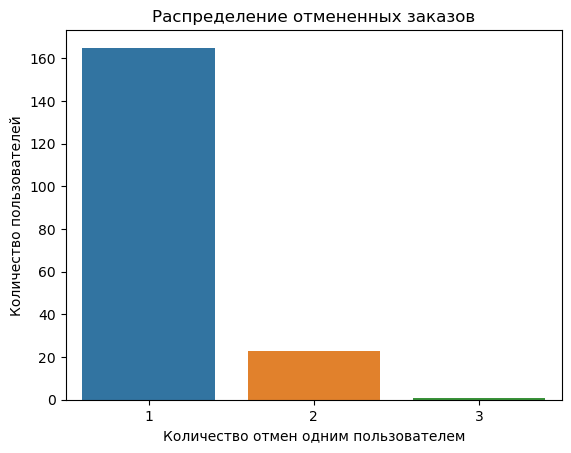

In [58]:
# Посмотрю как распределены значения из колонки total
sns.countplot(x='total', data=test_3)

# Добавлю название гистограмме и ее осям
plt.title('Распределение отмененных заказов')
plt.xlabel('Количество отмен одним пользователем')
plt.ylabel('Количество пользователей')

print("\033[1mВариативность количества отмененных заказов небольшая. Значения total распределены несимметрично.\033[0m")

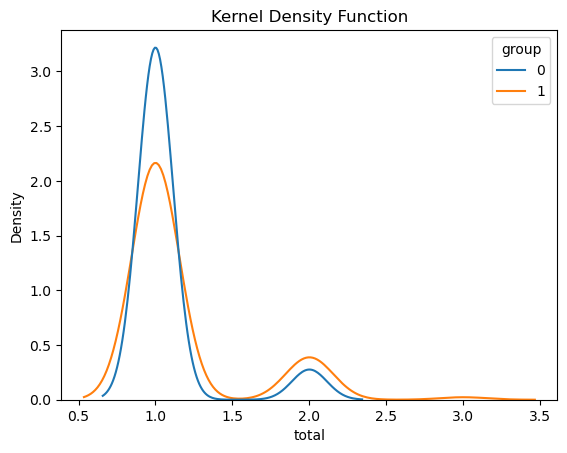

In [59]:
# При помощи kdeplot посмотрю на плотность распределения значений для каждой группы
sns.kdeplot(x='total', data=test_3, hue='group', common_norm=False);
plt.title("Kernel Density Function");
plt.show()

In [60]:
# Посмотрю на количество уникальных user_id в каждой группе, для того что бы понять равны группы между собой или нет
number_user_id = test_3.groupby(['group']) \
                       .agg({'user_id': 'nunique'}) \
                       .rename(columns=({'user_id': 'amount'}))
delta_percent = (number_user_id['amount'].max() / number_user_id['amount'].min()) * 100 - 100
print(number_user_id)
print(f"\033[1mРазница между группами {delta_percent:.2f} %, группы ощутимо различаются по количеству наблюдений. \033[0m")

       amount
group        
0          76
1         113
Разница между группами 48.68 %, группы ощутимо различаются по количеству наблюдений. 


### Статистические тесты

#### Проверка нормальности распределения данных при помощи **pg.normality**  

**<u>Определю гипотезы:</u>**  
* H0: значения из колонки total распределены нормально  
* H1: распределение значений из колонки total является ненормальным

In [61]:
pg.normality(data=test_3, dv='total', group='group', method='normaltest')

,W,pval,normal
group,,,
0,69.857481,6.770813e-16,False
1,61.435658,4.564744e-14,False


**Вывод:**  
Значения p-value в обеих группах меньше альфа-уровня (0.05). Это означает, что у меня нет достаточных оснований, что бы принять H0.<br>
**Принимаю H1**, распределение значений из колонки total является ненормальным.

#### Проверка данных на нормальность и гомогенность (гомоскедастичность) дисперсии 

Для проверки равенства дисперсий в группах воспользуюсь тестом Левина, т.к. его рекомендуется использовать при ненормальном распределении.  

**<u>Определю гипотезы:</u>**  
* H0: дисперсии между группами равны
* H1: дисперсии между группами не равны

In [62]:
# Воспользуюсь функцией check_tail_heaviness для определения типа хвоста (тяжелый/легкий) 
check_tail_heaviness(test_3['total'])

 Данные имеют тяжелый хвост (p-value: 7.146283617261706e-151) 


In [63]:
# Сравню дисперсии тестом Левина. Параметр center='trimmed' — рекомендуется для распределений с тяжелыми хвостами
test_stat, pvalue = st.levene(test_3[test_3.group == 0].total, test_3[test_3.group == 1].total, center='trimmed')
if pvalue > 0.05:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня не имеется достаточных оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. \033[0m")
else:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.\033[0m")

Вывод: 
Статистика = 15.63, p-value = 0.00011246887191707234.
Это означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.


### Итог по результатам статистических тестов и визуальной проверки
Исходя из предварительного анализа, результатов теста на нормальность и гомогенность дисперсий можно использовать t-test с поправкой Уэлча, применяется в случае неравных дисперсий. Особенно поправка важна, если размеры двух выборок сильно различаются. В остальном все как у обычного т-теста — если выборки большие, нормальность становится не так уж важна (в силу разных теорем, в том числе ЦПТ).

### Welch’s t-test
<b>Тип данных:</b> количественные, дискретные.<br>
<b>Целевая метрика:</b> среднее количество отмененных заказов<br>

**<u>Определю гипотезы:</u>**
* H0 - между контрольной и экспериментальной группой нет никакой статистически значимой разницы в среднем количестве отмененных заказов<br>
* H1 -наблюдаемый эффект это результат внедрения в приложение умной системы рекомендации товаров, разница статистически значима

In [64]:
st.ttest_ind(test_3[test_3.group == 0].total, test_3[test_3.group == 1].total, equal_var = False)

TtestResult(statistic=-1.8296891493675829, pvalue=0.06888907857362961, df=186.96279984261517)

<b>Вывод:</b><br>
P-value больше альфа-уровня (0.05). Таким образом у меня не имеется достаточных оснований, чтобы сказать, что значения в группах статистически значимо различаются. **Принимаю H0.**<br>
Рекомендация товаров существенно не повлияла на среднее количество отмененных заказов. Среднее количество отмененных заказов между экспериментальной и контрольной группой статистически значимо не различается.

## Test #4 (среднее количество заказов на пользователя)
**Посмотрю на среднее количество заказов (не считая отмененные) на пользователя в каждой группе**  

In [65]:
test_4 = not_cancel_ordrs_df.groupby(['user_id', 'group'], as_index=False) \
                            .agg({'order_id': 'nunique'}) \
                            .groupby(['group']) \
                            .agg({'order_id': 'mean'}) \
                            .round(2) \
                            .rename(columns=({'order_id': 'avg_number_of_orders'}))
delta_percent = (test_4['avg_number_of_orders'].max() / test_4['avg_number_of_orders'].min()) * 100 - 100
print(test_4)
print()
print(f"\033[1mЕсть различия, у тестовой группы среднее количество заказов на пользователя больще на {delta_percent:.2f} %. При помощи статистического теста определю статистически значимы эти различия или нет. \033[0m")

       avg_number_of_orders
group                      
0                      2.98
1                      4.75

Есть различия, у тестовой группы среднее количество заказов на пользователя больще на 59.40 %. При помощи статистического теста определю статистически значимы эти различия или нет. 


In [66]:
# Подготовлю датафрейм для проведения теста
test_4 = not_cancel_ordrs_df.groupby(['user_id', 'group'], as_index=False) \
                            .agg({'order_id': 'nunique'}) \
                            .rename(columns=({'order_id': 'amount'}))
test_4.head(3)

,user_id,group,amount
0,964,0,2
1,965,1,9
2,967,1,5


### Визуальная проверка

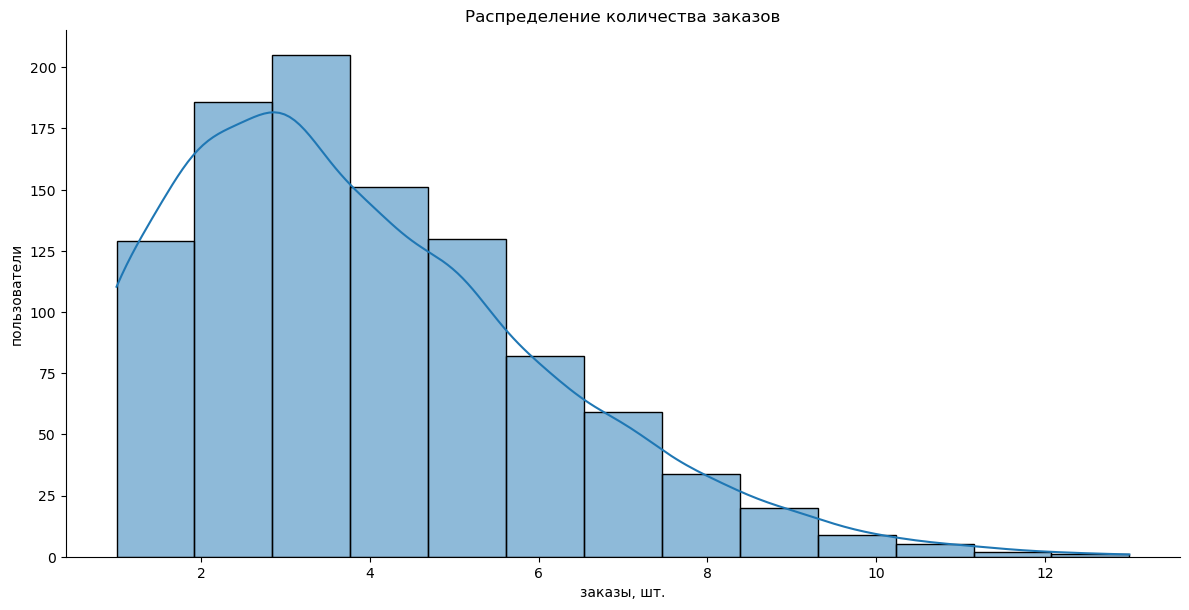

Значения отдаленно напоминают нормальное распределение с большим хвостом справа 


In [67]:
# Посмотрю как распределены значения из колонки amount
sns.displot(data=test_4, x="amount", kde=True, height= 6, aspect= 2, bins=13)
# Добавлю название гистограмме и ее осям
plt.title('Распределение количества заказов')
plt.xlabel('заказы, шт.')
plt.ylabel('пользователи')
plt.show()

print("\033[1mЗначения отдаленно напоминают нормальное распределение с большим хвостом справа \033[0m")

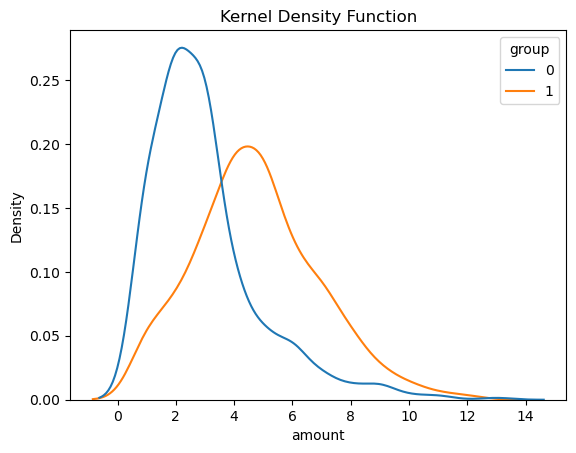

In [68]:
# При помощи kdeplot посмотрю на плотность распределения значений для каждой группы
sns.kdeplot(x='amount', data=test_4, hue='group', common_norm=False);
plt.title("Kernel Density Function");
plt.show()

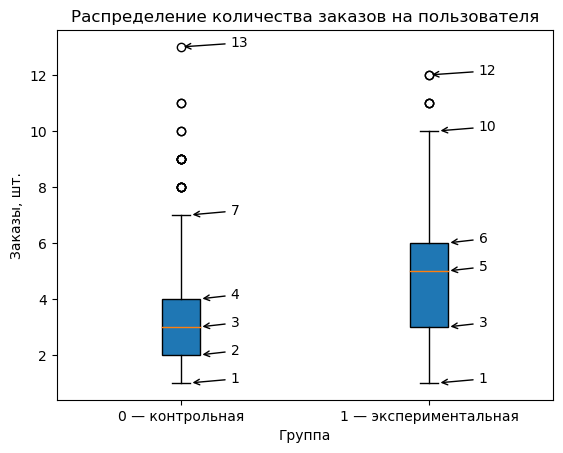

В контрольной группе имеется больше выбросов, максимальное значение = 13, относится к user_id 1170. 
В экспериментальной группе выбросов меньше, максимальное значение = 12, относится к user_id 1537 и 1583. 
В общем и целом видно, что в экспериментальной группе количество заказов на пользователя больше чем в контрольной группе. 


In [69]:
# Разделю на отдельные группы
data0 = test_4[test_4.group == 0]['amount'].values  # контрольная группа
data1 = test_4[test_4.group == 1]['amount'].values  # экспериментальная группа

# Создание боксплота
fig, ax = plt.subplots()
bp = ax.boxplot([data0, data1], patch_artist=True)

# Добавлю название гистограмме и ее осям
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Группа')
plt.ylabel('Заказы, шт.')

# Подпись значений квартилей, усов и выбросов для каждой группы
for i, group_data in enumerate([data0, data1], start=0):
    
    quartiles = np.percentile(group_data, [25, 50, 75])
    
    # Подписи квартилей
    for q in quartiles:
        ax.annotate(f'{q:.0f}', xy=(i + 1.075, q), xytext=(i + 1.2, q),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')

    # Подписи усов и самых максимальных выбросов
    max_val = np.max(group_data)
    if max_val != upper_whiskers:
        ax.annotate(f'{max_val:.0f}', xy=(i + 1, max_val), xytext=(i + 1.2, max_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')

    lower_whiskers =  bp['whiskers'][2 * i].get_ydata()[1]
    upper_whiskers = bp['whiskers'][2 * i + 1].get_ydata()[1]     
    ax.annotate(f'{lower_whiskers:.0f}', xy=(i + 1.035, lower_whiskers), xytext=(i + 1.2, lower_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')
    ax.annotate(f'{upper_whiskers:.0f}', xy=(i + 1.035, upper_whiskers), xytext=(i + 1.2, upper_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')

# Настройка меток осей
ax.set_xticklabels(['0 — контрольная', '1 — экспериментальная'])
plt.show()

print("\033[1mВ контрольной группе имеется больше выбросов, максимальное значение = 13, относится к user_id 1170. \033[0m")
print("\033[1mВ экспериментальной группе выбросов меньше, максимальное значение = 12, относится к user_id 1537 и 1583. \033[0m")
print("\033[1mВ общем и целом видно, что в экспериментальной группе количество заказов на пользователя больше чем в контрольной группе. \033[0m")

In [70]:
# Контрольная группа, user_id со значением amount == 13
test_4.query("group == 0 and amount == 13")

,user_id,group,amount
204,1170,0,13


In [71]:
# order_id и количество товаров в каждом заказе для пользователя 1170
all_df.query("user_id == 1170") \
      .groupby(['order_id'], as_index=False) \
      .agg({'user_id': 'count'}) \
      .rename(columns=({'user_id': 'number_of_positions'})) \
      .sort_values('order_id')

,order_id,number_of_positions
0,1542,5
1,1779,3
2,2727,1
3,3149,3
4,3153,4
5,9826,3
6,19971,3
7,21652,2
8,21736,3
9,30094,5


In [72]:
# экспериментальная группа, user_id со значением amount == 12
test_4.query("group == 1 and amount == 12")

,user_id,group,amount
570,1537,1,12
616,1583,1,12


In [73]:
# order_id и количество товаров в каждом заказе для пользователей 1537 и 1583
all_df.query("user_id in [1537, 1583]") \
      .groupby(['order_id', 'user_id'], as_index=False) \
      .agg({'product_id': 'count'}) \
      .rename(columns=({'product_id': 'number_of_positions'})) \
      .sort_values(['user_id', 'order_id'])

,order_id,user_id,number_of_positions
0,2052,1537,4
3,4293,1537,2
4,4589,1537,4
5,7496,1537,2
10,16619,1537,2
15,39379,1537,2
16,39390,1537,3
17,39874,1537,3
18,40377,1537,1
20,53390,1537,2


### Статистические тесты

#### Проверка нормальности распределения данных при помощи **pg.normality**  

**<u>Определю гипотезы:</u>**  
* H0: значения из колонки amount распределены нормально  
* H1: распределение значений из колонки amount является ненормальным

In [74]:
pg.normality(data=test_4, dv='amount', group='group', method='normaltest')

,W,pval,normal
group,,,
0,178.266627,1.949368e-39,False
1,17.210719,1.831217e-04,False


**Вывод:**  
Значения p-value в обеих группах меньше альфа-уровня (0.05). Это означает, что у меня нет достаточных оснований, что бы принять H0.<br>
**Принимаю H1**, распределение значений из колонки amount является ненормальным.

#### Проверка данных на нормальность и гомогенность (гомоскедастичность) дисперсии 

Для проверки равенства дисперсий в группах воспользуюсь тестом Левина, т.к. его рекомендуется использовать при ненормальном распределении.  

**<u>Определю гипотезы:</u>**  
* H0: дисперсии между группами равны
* H1: дисперсии между группами не равны

In [75]:
# Воспользуюсь функцией check_tail_heaviness для определения типа хвоста (тяжелый/легкий) 
check_tail_heaviness(test_4['amount'])

 Данные имеют тяжелый хвост (p-value: 0.0) 


In [76]:
# Сравню дисперсии тестом Левина. Параметр center='trimmed' — рекомендуется для распределений с тяжелыми хвостами
test_stat, pvalue = st.levene(test_4[test_4.group == 0].amount, test_4[test_4.group == 1].amount, center='trimmed')
if pvalue > 0.05:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня не имеется достаточных оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. \033[0m")
else:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.\033[0m")

Вывод: 
Статистика = 28.87, p-value = 9.812203329089464e-08.
Это означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.


In [77]:
# Посмотрю на количество значений в каждой группе
number_user_id = test_4.groupby(['group']) \
                       .agg({'user_id': 'nunique'}) \
                       .rename(columns=({'user_id': 'amount'}))
delta_percent = (number_user_id['amount'].max() / number_user_id['amount'].min()) * 100 - 100
print(number_user_id)
print()
print(f"\033[1mКоличество значений в контрольной группе на {delta_percent:.2f} % больше чем в экспериментальной группе. Разница небольшая, группы можно считать равными по количеству наблюдений. \033[0m")

       amount
group        
0         512
1         501

Количество значений в контрольной группе на 2.20 % больше чем в экспериментальной группе. Разница небольшая, группы можно считать равными по количеству наблюдений. 


### Итог по результатам статистических тестов и визуальной проверки
Исходя из предварительного анализа, результатов теста на нормальность и гомогенность дисперсий можно использовать t-test с поправкой Уэлча, применяется в случае неравных дисперсий. Особенно поправка важна, если размеры двух выборок сильно различаются. В остальном все как у обычного т-теста — если выборки большие, нормальность становится не так уж важна (в силу разных теорем, в том числе ЦПТ).

### Welch’s t-test
<b>Тип данных:</b> количественные, дискретные.<br>
<b>Целевая метрика:</b> среднее количество заказов на пользователя<br>

**<u>Определю гипотезы:</u>**
* H0 - между контрольной экспериментальной группой нет никакой статистически значимой разницы в среднем количестве заказов на пользователя<br>
* H1 - наблюдаемый эффект это результат внедрения в приложение умной системы рекомендации товаров, разница статистически значима

In [78]:
st.ttest_ind(test_4[test_4.group == 0].amount, test_4[test_4.group == 1].amount, equal_var = False)

TtestResult(statistic=-13.974169980221783, pvalue=1.2374101233656574e-40, df=989.8228352282781)

<b>Вывод:</b><br>
P-value меньше альфа-уровня (0.05). Таким образом у меня имеется достаточно оснований что бы отвергнуть H0 и **принять H1**. Делаю вывод, что разница между средним количеством заказов на пользователя в каждой группе статистически значима и является результатом внедрения в приложение умной системы рекомендации товаров.

# Целевая метрика

## Test #5 (средняя выручка на пользователя в каждой группе)  
**Посмотрю на среднюю выручку в разрезе по пользователям в каждой группе** 

In [79]:
test_5 = not_cancel_ordrs_df.groupby(['user_id', 'group'], as_index=False) \
                            .agg({'price': 'sum'}) \
                            .groupby(['group']) \
                            .agg({'price': 'mean'}) \
                            .round(2) \
                            .rename(columns=({'price': 'avg_revenue'}))
delta_percent = (test_5['avg_revenue'].max() / test_5['avg_revenue'].min()) * 100 - 100
print(test_5)
print()
print(f"\033[1mЕсть различия, у экспериментальной группы средняя выручка на пользователя больще на {delta_percent:.1f} %. При помощи статистического теста определю статистически значимы эти различия или нет. \033[0m")

       avg_revenue
group             
0          1139.56
1          1753.75

Есть различия, у экспериментальной группы средняя выручка на пользователя больще на 53.9 %. При помощи статистического теста определю статистически значимы эти различия или нет. 


In [80]:
# Подготовлю датафрейм для проведения теста. Суммарная выручка по каждому пользователю
test_5 = not_cancel_ordrs_df.groupby(['user_id', 'group'], as_index=False) \
                            .agg({'price': 'sum'}) \
                            .rename(columns=({'price': 'total'}))
print("\033[1m total —  суммарная выручка на пользователя \033[1m")
test_5.head(3)

 total —  суммарная выручка на пользователя 


,user_id,group,total
0,964,0,718.9
1,965,1,4155.5
2,967,1,1137.4


### Визуальная проверка

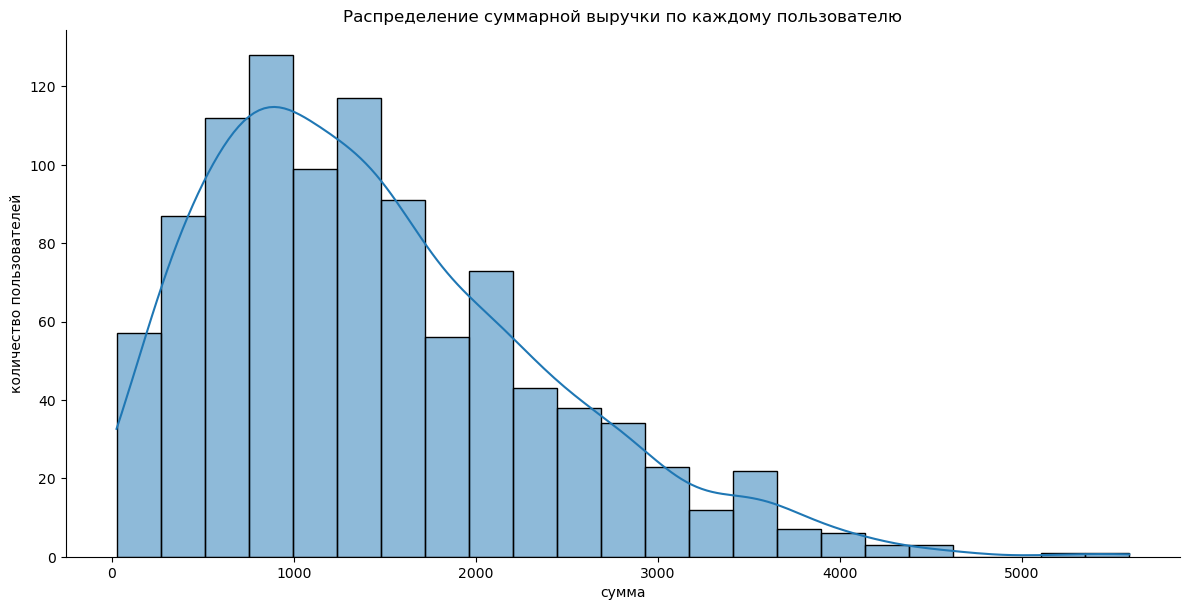

 Значения распределены относительно симметрично, но с большим хвостом справа 


In [81]:
# Посмотрю как распределены значения из колонки total
sns.displot(data=test_5, x="total", kde=True, height= 6, aspect= 2)
# Добавлю название гистограмме и ее осям
plt.title('Распределение суммарной выручки по каждому пользователю')
plt.xlabel('сумма')
plt.ylabel('количество пользователей')
plt.show()

print("\033[1m Значения распределены относительно симметрично, но с большим хвостом справа \033[0m")

In [82]:
# Добавлю колонку с прологарифмированными значениями, что бы сделать распределения более симметричными
test_5['total_log'] = np.log(test_5.total)

print("\033[1m total_log — прологарифмированная выручка на пользователя \033[1m")
test_5.head(3)

 total_log — прологарифмированная выручка на пользователя 


,user_id,group,total,total_log
0,964,0,718.9,6.577722
1,965,1,4155.5,8.332188
2,967,1,1137.4,7.036500


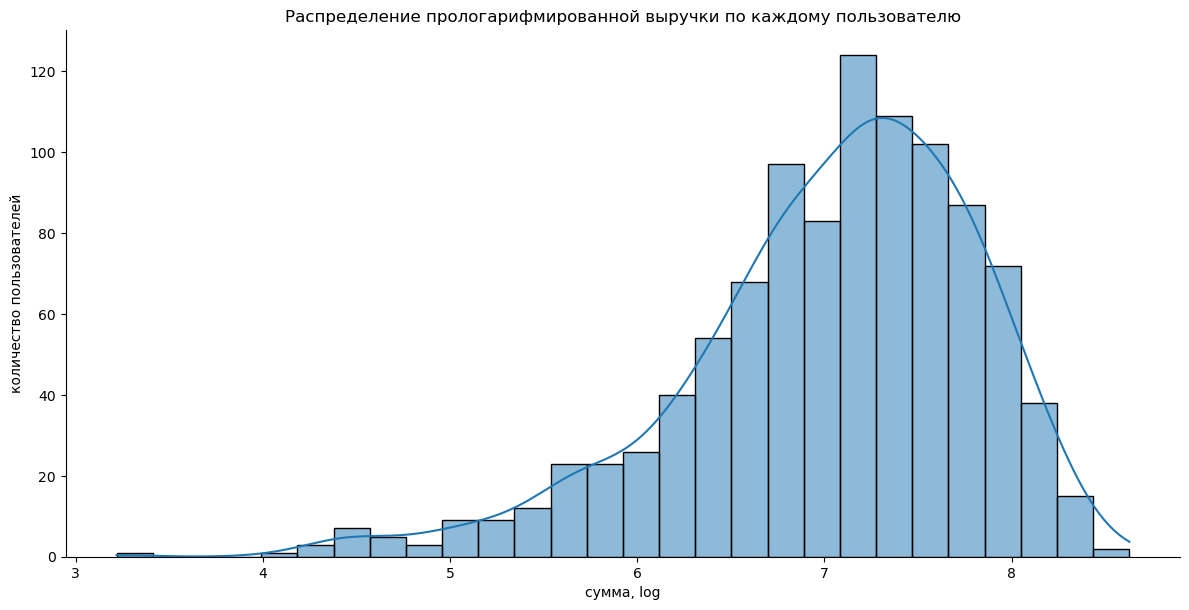

Распределение имеет более симметричный вид, в отличие от непрологарифмированных значений. Имеется ощутимый хвост слева. Дальше в тесте буду работать со значениями из total_log.  


In [83]:
# Посмотрю на прологарифмированные значения из колонки total_log
sns.displot(data=test_5, x="total_log", kde=True, height= 6, aspect= 2)

# Добавлю название гистограмме и ее осям
plt.title('Распределение прологарифмированной выручки по каждому пользователю')
plt.xlabel('сумма, log')
plt.ylabel('количество пользователей')
plt.show()

print("\033[1mРаспределение имеет более симметричный вид, в отличие от непрологарифмированных значений. Имеется ощутимый хвост слева. Дальше в тесте буду работать со значениями из total_log.  \033[0m")

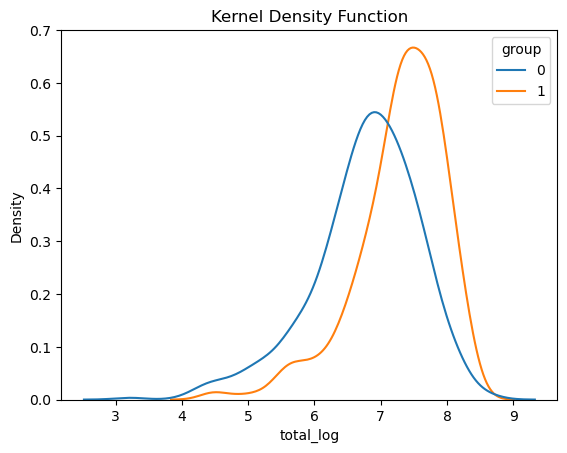

In [84]:
# При помощи kdeplot посмотрю на плотность распределения значений для каждой группы
sns.kdeplot(x='total_log', data=test_5, hue='group', common_norm=False);
plt.title("Kernel Density Function");
plt.show()

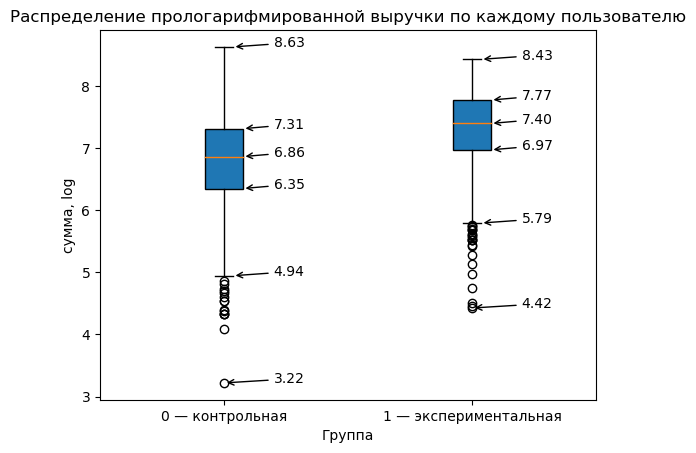

Видно, что в экспериментальной группе выручка по каждому пользователю больше чем в контрольной группе. 


In [85]:
# Разделю на отдельные группы
data0 = test_5[test_5.group == 0]['total_log'].values  # контрольная группа
data1 = test_5[test_5.group == 1]['total_log'].values  # экспериментальная группа

# Создание боксплота
fig, ax = plt.subplots()
bp = ax.boxplot([data0, data1], patch_artist=True)

# Добавлю название гистограмме и ее осям
plt.title('Распределение прологарифмированной выручки по каждому пользователю')
plt.xlabel('Группа')
plt.ylabel('сумма, log')

# Подпись значений квартилей, усов и выбросов для каждой группы
for i, group_data in enumerate([data0, data1], start=0):
    
    quartiles = np.percentile(group_data, [25, 50, 75])
    
    # Подписи квартилей (25, 50, 75)
    for q in quartiles:
        ax.annotate(f'{q:.2f}', xy=(i + 1.075, q), xytext=(i + 1.2, q),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')

    
    # Максимальное и минимальное значение в группе
    max_val = np.max(group_data)
    min_val = np.min(group_data)

    # Значения усов (верхний и нижний)
    lower_whiskers =  bp['whiskers'][2 * i].get_ydata()[1]
    upper_whiskers = bp['whiskers'][2 * i + 1].get_ydata()[1]  
    
    # Подписи выбросов (максимальных и минимальных)
    if max_val != upper_whiskers:
        ax.annotate(f'{max_val:.2f}', xy=(i + 1, max_val), xytext=(i + 1.2, max_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')
    if min_val != lower_whiskers:
        ax.annotate(f'{min_val:.2f}', xy=(i + 1, min_val), xytext=(i + 1.2, min_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')    
   
    # Подписи усов (верхний и нижний)
    ax.annotate(f'{lower_whiskers:.2f}', xy=(i + 1.035, lower_whiskers), xytext=(i + 1.2, lower_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')
    ax.annotate(f'{upper_whiskers:.2f}', xy=(i + 1.035, upper_whiskers), xytext=(i + 1.2, upper_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')

# Настройка меток осей
ax.set_xticklabels(['0 — контрольная', '1 — экспериментальная'])
plt.show()


print("\033[1mВидно, что в экспериментальной группе выручка по каждому пользователю больше чем в контрольной группе. \033[0m")

### Статистические тесты

#### Проверка нормальности распределения данных при помощи **pg.normality**  

**<u>Определю гипотезы:</u>**  
* H0: значения из колонки total_log распределены нормально  
* H1: распределение значений из колонки total_log является ненормальным

In [86]:
pg.normality(data=test_5, dv='total_log', group='group', method='normaltest')

,W,pval,normal
group,,,
0,58.302072,2.187086e-13,False
1,109.161585,1.976347e-24,False


**Вывод:**  
Значения p-value в обеих группах меньше альфа-уровня (0.05). Это означает, что нет достаточных оснований, что бы принять H0.<br>
**Принимаю H1**, распределение значений из колонки total_log является ненормальным.

#### Проверка данных на нормальность и гомогенность (гомоскедастичность) дисперсии  

Для проверки равенства дисперсий в группах воспользуюсь тестом Левина, т.к. его рекомендуется использовать при ненормальном распределении.  

**<u>Определю гипотезы:</u>**  
* H0: дисперсии между группами равны
* H1: дисперсии между группами не равны

In [87]:
# Воспользуюсь функцией check_tail_heaviness для определения типа хвоста (тяжелый/легкий) 
check_tail_heaviness(test_5['total_log'])

 Данные имеют тяжелый хвост (p-value: 0.0) 


In [88]:
# Сравню дисперсии тестом Левина. Параметр center='trimmed' — рекомендуется для распределений с тяжелыми хвостами
test_stat, pvalue = st.levene(test_5[test_5.group == 0].total_log, test_5[test_5.group == 1].total_log, center='trimmed')
if pvalue > 0.05:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня не имеется достаточных оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value больше 0.05, принимаю H0. \033[0m")
else:
    print(f"\033[1mВывод: \nСтатистика = {round(test_stat, 2)}, p-value = {pvalue}.\nЭто означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.\033[0m")

Вывод: 
Статистика = 17.4, p-value = 3.322419090123867e-05.
Это означает, что у меня имеется достаточно оснований, чтобы сказать, что дисперсии не равны. Поскольку p-value меньше 0.05, принимаю H1.


In [89]:
# Посмотрю на количество значений в каждой группе
number_user_id = test_5.groupby(['group']) \
                       .agg({'user_id': 'nunique'}) \
                       .rename(columns=({'user_id': 'amount'}))
delta_percent = (number_user_id['amount'].max() / number_user_id['amount'].min()) * 100 - 100
print(number_user_id)
print()
print(f"\033[1mКоличество значений в контрольной группе на {delta_percent:.2f} % больше чем в экспериментальной группе. Разница небольшая, группы можно считать равными по количеству наблюдений. \033[0m")

       amount
group        
0         512
1         501

Количество значений в контрольной группе на 2.20 % больше чем в экспериментальной группе. Разница небольшая, группы можно считать равными по количеству наблюдений. 


### Итог по результатам статистических тестов и визуальной проверки
Исходя из предварительного анализа, результатов теста на нормальность и гомогенность дисперсий можно использовать t-test с поправкой Уэлча, применяется в случае неравных дисперсий. Особенно поправка важна, если размеры двух выборок сильно различаются. В остальном все как у обычного т-теста — если выборки большие, нормальность становится не так уж важна (в силу разных теорем, в том числе ЦПТ).

### Welch’s t-test
<b>Тип данных:</b> количественные, непрерывные.<br>
<b>Целевая метрика:</b> среднее количество заказов на пользователя<br>

**<u>Определю гипотезы:</u>**
* H0 - между контрольной  и экспериментальной группой нет никакой статистически значимой разницы в среднем количестве заказов на пользователя<br>
* H1 - наблюдаемый эффект это результат внедрения в приложение умной системы рекомендации товаров, разница статистически значима

In [90]:
st.ttest_ind(test_5[test_5.group == 0].total_log, test_5[test_5.group == 1].total_log, equal_var = False)

TtestResult(statistic=-11.104581066109354, pvalue=4.408529873882794e-27, df=988.766906416109)

<b>Вывод:</b><br>
P-value меньше альфа-уровня (0.05). Таким образом у меня имеется достаточно оснований, что бы отвергнуть H0 и **принять H1**. Делаю вывод, что разница между средней выручкой на пользователя в каждой группе статистически значима и является результатом внедрения в приложение умной системы рекомендации товаров.

# Заключение
Следует раскатать новую систему рекомендаций на всех пользователей исходя из того, что выросло количество заказов на пользователя, а вместе с этим и средняя выручка.